# Day 2: Planning a Road Trip

### Problem:

My friend VictORia and I are planning a road trip.

We want to drive from Madrid to Copenhagen and we've seen there are a lot of ways to do it.

Most probably, even if we wanted to go through Budapest, we cannot go that path. We have a limited budget for fuel of 73€, and we want to get the shortest possible way.

Can you help me solve this problem?

In instance.txt we can find an instance of the problem.

### Solution:

The aim of this problem is to minimize the path, i.e., minimize the number of visiting nodes subject to the fuel restriction.

This problem is an example of a Shortest Path problem, where we have $100$ cities and we want to minimize the number of cities visited to arrive Copenhagen starting from Madrid. Also, we have a limit budget for fuel of $73$€.

To start with this problem, we firstly print the graph for the available instance, which it contains a map of the cities where the city 1 is Madrid and the city 100 is Copenhagen, our 
destination.

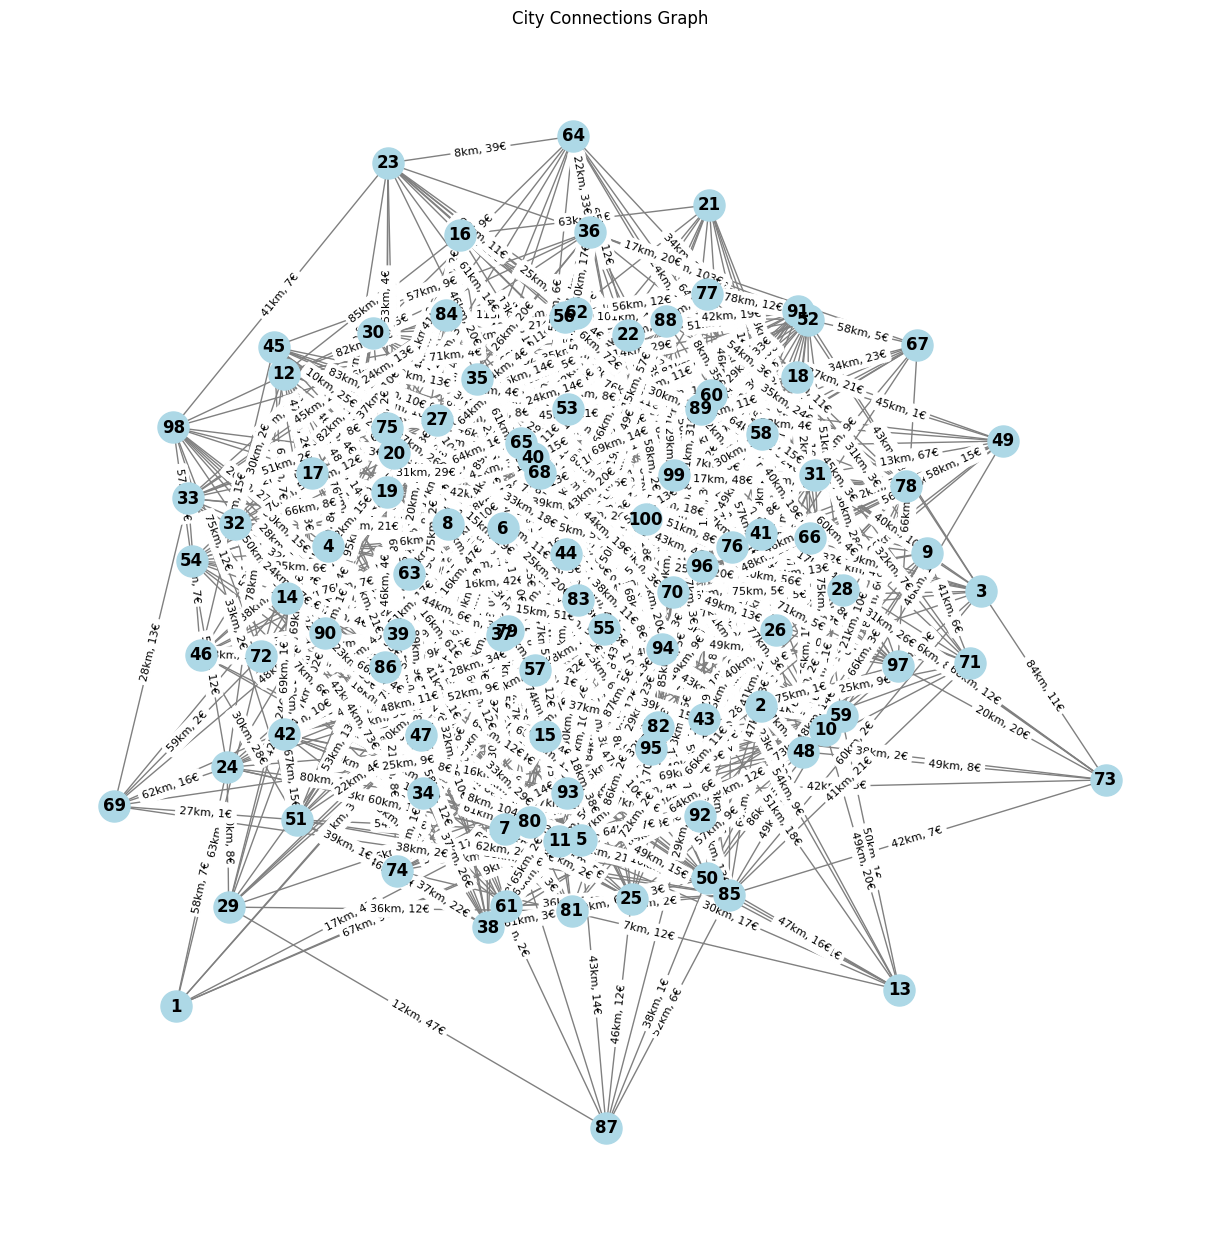

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

file_path = "instance.txt"

graph = nx.Graph()
data = []

with open(file_path, 'r') as file:
    lines = file.readlines()
    for line in lines[2:]:  # Skip the first two lines
        parts = line.split()
        if len(parts) == 4:
            city1, city2, distance, fuel_cost = map(int, parts)
            data.append({"city1": city1, "city2": city2, "distance": distance, "fuel_cost": fuel_cost})
            graph.add_edge(city1, city2, weight=distance, fuel_cost=fuel_cost)

df = pd.DataFrame(data)

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(graph)  # Layout for better visualization
nx.draw(
    graph,
    pos,
    with_labels=True,
    node_size=500,
    node_color="lightblue",
    edge_color="gray",
    font_weight="bold"
)
# Add edge labels (distance and fuel cost)
edge_labels = {
    (u, v): f"{d['weight']}km, {d['fuel_cost']}€"
    for u, v, d in graph.edges(data=True)
}
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

plt.title("City Connections Graph")
plt.show()

In [2]:
df

,city1,city2,distance,fuel_cost
0,1,37,60,5
1,1,59,9,59
2,1,72,63,1
3,2,15,61,1
4,2,20,16,39
...,...,...,...,...
950,100,79,41,2
951,100,83,49,1
952,100,88,8,57
953,100,91,37,10


Once we have the data loaded, let's minimize. In out problem we want to minimize the path we will take from Madrid to Copenaghen where we can not spend more than $73$€ in fuel. Hence, our problem will be defined as:

$$
\begin{align*}
\text{minimize}_{\theta_{ij}} \quad & \sum_{i=1}^{100}\sum_{j=1}^{100} d_{ij}\theta_{ij}\\
\text{subject to} \quad & \sum_{j=1}^{100}\theta_{1j} = 1\\
& \sum_{i=1}^{100}\theta_{i100} = 1 \\
& \sum_{i=1}^{100}\theta_{ik} = \sum_{j=1}^{100}\theta_{kj} \quad \forall k=1,\dots,100\\
& \sum_{i,j=1}^{100}f_{ij}\theta_{ij} \leq 73 \\
& \theta_{ij}\in\lbrace 0,1\rbrace \quad \forall i,j =1,\dots,100

\end{align*}
$$

where $d_{ij}$ correspond to the distance between city $i$ and city $j$ and $f_{ij}$ correspond to cost fuel from city $i$ to city $j$.

In order to solve this problem, we will use Pyomo.

In [ ]:
from pyomo.environ import *
import numpy as np

# Extract the data from the dataframe we created before
edges = list(zip(df["city1"], df["city2"]))
distance = {(row.city1, row.city2): row.distance for _, row in df.iterrows()}
fuel_cost = {(row.city1, row.city2): row.fuel_cost for _, row in df.iterrows()}
cities = np.arange(1,101)

# Parameters
start_city = 1
end_city = 100
fuel_budget = 73

# Create the model
model = ConcreteModel()

## Sets
model.edges = Set(initialize=edges, dimen=2)    # Edge set
model.cities = Set(initialize=cities)           # City set

## Variables
model.x = Var(model.edges, within=Binary)  # Decision variable: 1 if edge (i,j) is used, else 0, we defined as theta

## Objective: Minimize total distance
model.obj = Objective(expr=sum(distance[e] * model.x[e] for e in model.edges), sense=minimize)

## Constraints
# Start at city 1
model.start = Constraint(expr=sum(model.x[e] for e in model.edges if e[0] == start_city) == 1)

# End at city 100
model.end = Constraint(expr=sum(model.x[e] for e in model.edges if e[1] == end_city) == 1)

# Flow constraint
def flow_balance_rule(model, city):
    if city != start_city and city != end_city:
        return sum(model.x[e] for e in model.edges if e[1] == city) == sum(model.x[e] for e in model.edges if e[0] == city)
    return Constraint.Skip
model.flow_balance = Constraint(model.cities, rule=flow_balance_rule)

# Budget constraint on fuel cost
model.fuel_budget = Constraint(expr=sum(fuel_cost[e] * model.x[e] for e in model.edges) <= fuel_budget)

# Solve the model
solver = SolverFactory('glpk')  
solver.solve(model)

# Extract and print the results
if model.obj() is not None:
    print("Optimal Path Found!")
    path = [e for e in model.edges if model.x[e]() == 1]
    total_distance = model.obj()
    total_fuel_cost = sum(fuel_cost[e] for e in path)
    print(f"Path: {path}")
    print(f"Total Distance: {total_distance}")
    print(f"Total Fuel Cost: {total_fuel_cost}")
else:
    print("No feasible path found under the given budget.")


Optimal Path Found!
Path: [(1, 37), (2, 100), (37, 41), (41, 2)]
Total Distance: 131.0
Total Fuel Cost: 44
